<a href="https://colab.research.google.com/github/zdanielshi/data_science_LFZ/blob/main/DS_0628_Kaggle_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler, MaxAbsScaler, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("error")

pd.set_option('display.float_format', lambda x: '%.5f' % x)

from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Colab data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Colab data/test.csv')

In [4]:
train.shape

(1460, 81)

In [5]:
test.shape

(1459, 80)

# Stacking the two tables
Also separating out price feature into it's own column

In [6]:
y = pd.DataFrame(train['SalePrice'])

In [7]:
y.describe()

,SalePrice
count,1460.00000
mean,180921.19589
std,79442.50288
min,34900.00000
25%,129975.00000
50%,163000.00000
75%,214000.00000
max,755000.00000


In [8]:
# train.drop(columns = 'SalePrice', inplace=True)

In [9]:
x = pd.concat([train.drop(columns='SalePrice'), test], axis = 0)

In [10]:
x

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.00000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.00000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.00000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.00000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.00000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.00000,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.00000,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.00000,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.00000,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


Plan of attack
* Analysis
* Clean up
  * Nulls
  * Outlier values
* Feature engineering
* Numericals to categoricals
* Ordinals
* Do some correlation and pairplotting
* Drop columns
  * Use the xnum threshold method
* Preprocessing
  * Transforming
  * Scaling
  * Encoding
* Regression and analysis

# Analysis

In [11]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5a2d20ab90>]],
      dtype=object)

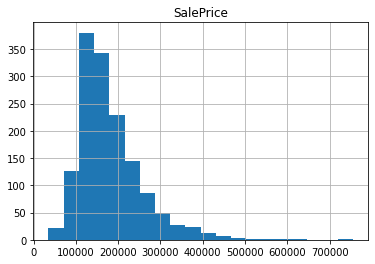

In [12]:
y.hist(bins = 20)

Correlations

In [13]:
# plt.figure(figsize =(30,10))
# heatmap = sns.heatmap(train.corr(), annot=True, vmin = -1, vmax = 1, cmap = 'BrBG')

## Clean up

#### Clean up columns where nulls = 'none'

* PoolQC - 'No pool'
* Fence - 'No fence'
* MiscFeature - 'No feature'
* Alley - 'No alley'
* BsmtQual - 'No basement'
* BsmtCond - 'No basement'
* BsmtExposure - 'No basement'
* BsmtFinType1 - 'No basement'
* BsmtFinType2 - 'No basement'
* FireplaceQu - 'No fireplace'
* GarageType - 'No garage'
* GarageYrBlt - 'No garage'
* GarageQual - 'No garage'
* GarageCond - 'No garage'


In [14]:
x.isnull().sum().sum()

13965

In [15]:
x.PoolQC.fillna('No Pool', inplace=True) # PoolQC 
x.Fence.fillna('No Fence', inplace=True) # Fence
x.MiscFeature.fillna('None', inplace=True) # MiscFeature
x.Alley.fillna('No alley access', inplace=True) # Alley
x.BsmtQual.fillna('No basement', inplace=True) # BsmtQual
x.BsmtCond.fillna('No basement', inplace=True) # BsmtCond
x.BsmtExposure.fillna('No basement', inplace=True) # BsmtExposure
x.BsmtFinType1.fillna('No basement', inplace=True) # BsmtFinType1
x.BsmtFinType2.fillna('No basement', inplace=True) # BsmtFinType2
x.FireplaceQu.fillna('No fireplace', inplace=True) # FireplaceQu
x.GarageType.fillna('No garage', inplace=True) # GarageType
x.GarageYrBlt.fillna('No garage', inplace=True) # GarageYrBlt
x.GarageQual.fillna('No garage', inplace=True) # GarageQual
x.GarageCond.fillna('No garage', inplace=True) # GarageCond
x.GarageFinish.fillna('No garage', inplace=True) # GarageFinish

In [16]:
x.isnull().sum().sum()

556

### Filling in nulls

In [17]:
isnull = x.isnull().sum().sort_values(ascending=False)
isnull = isnull[isnull > 0]
isnull

LotFrontage     486
MasVnrType       24
MasVnrArea       23
MSZoning          4
BsmtFullBath      2
BsmtHalfBath      2
Functional        2
Utilities         2
BsmtFinSF1        1
Exterior2nd       1
BsmtFinSF2        1
KitchenQual       1
GarageArea        1
BsmtUnfSF         1
TotalBsmtSF       1
Electrical        1
GarageCars        1
Exterior1st       1
SaleType          1
dtype: int64

In [18]:
isnull_under_100 = isnull[isnull < 100]
list_isnull_under_100 = isnull_under_100.index.tolist()

list_isnull_under_100

['MasVnrType',
 'MasVnrArea',
 'MSZoning',
 'BsmtFullBath',
 'BsmtHalfBath',
 'Functional',
 'Utilities',
 'BsmtFinSF1',
 'Exterior2nd',
 'BsmtFinSF2',
 'KitchenQual',
 'GarageArea',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Electrical',
 'GarageCars',
 'Exterior1st',
 'SaleType']

In [19]:
for i in list_isnull_under_100:
  try:
    x[i].fillna(x[i].median()[0], inplace=True)
  except:
    x[i].fillna(x[i].mode()[0], inplace=True)

In [20]:
isnull = x.isnull().sum().sort_values(ascending=False)
isnull = isnull[isnull > 0]
isnull

LotFrontage    486
dtype: int64

In [21]:
x.groupby('LotConfig')['LotFrontage'].median()

LotConfig
Corner    80.00000
CulDSac   50.00000
FR2       62.00000
FR3       66.00000
Inside    66.00000
Name: LotFrontage, dtype: float64

In [22]:
x.LotFrontage.fillna(x.groupby('LotConfig')['LotFrontage'].transform('median'),inplace=True)

In [23]:
isnull = x.isnull().sum().sort_values(ascending=False)
isnull = isnull[isnull > 0]
isnull

Series([], dtype: int64)

### Looking for outliers

### Fix some categoricals
* CentralAir: make it 1 and 0

In [24]:
x['CentralAir'] = x['CentralAir'].apply(lambda x: 1 if x == 'Y' else 0)

In [25]:
x['CentralAir'] = x['CentralAir'].astype('object')

# Feature Engineering

#### Features to engineer
1. Total square footage (sum all of the sq fts)
1.  Total # of bathrooms
1.  Total porch sq
1.  Does it have a pool?
1.  Does it have a 2nd floor?
1. Does it have a garage
1. Does it have a basement?
1. Does it have a fireplace?

In [26]:
# Total square footage

In [27]:
# Total # of bathrooms

In [28]:
# Total porch square footage

In [29]:
# Does it have a pool (2906)
x['HasPool'] = x['PoolArea'].apply(lambda x: 1 if x >0 else 0).astype('category')

In [30]:
# Does it have a 2nd floor
x['Has2ndFloor'] = x['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0).astype('category')

In [31]:
# Does it have a garage
x['HasGarage'] = x['GarageArea'].apply(lambda x: 1 if x > 0 else 0).astype('category')

In [32]:
# Does it have a basement
x['HasBasement'] = x['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0).astype('category')

In [33]:
# Does it have a fireplace?
x['HasFireplace'] = x['Fireplaces'].apply(lambda x: 1 if x > 0 else 0).astype('category')

# Preprocessing

Changing objects to numericals

In [34]:
xcat = x.select_dtypes(include='object')
xcat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 44 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       2919 non-null   object
 1   Street         2919 non-null   object
 2   Alley          2919 non-null   object
 3   LotShape       2919 non-null   object
 4   LandContour    2919 non-null   object
 5   Utilities      2919 non-null   object
 6   LotConfig      2919 non-null   object
 7   LandSlope      2919 non-null   object
 8   Neighborhood   2919 non-null   object
 9   Condition1     2919 non-null   object
 10  Condition2     2919 non-null   object
 11  BldgType       2919 non-null   object
 12  HouseStyle     2919 non-null   object
 13  RoofStyle      2919 non-null   object
 14  RoofMatl       2919 non-null   object
 15  Exterior1st    2919 non-null   object
 16  Exterior2nd    2919 non-null   object
 17  MasVnrType     2919 non-null   object
 18  ExterQual      2919 non-null

In [35]:
xnum = x.select_dtypes(include = 'number')

In [36]:
xnum

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,60,65.00000,8450,7,5,2003,2003,196.00000,706.00000,...,548.00000,0,61,0,0,0,0,0,2,2008
1,2,20,80.00000,9600,6,8,1976,1976,0.00000,978.00000,...,460.00000,298,0,0,0,0,0,0,5,2007
2,3,60,68.00000,11250,7,5,2001,2002,162.00000,486.00000,...,608.00000,0,42,0,0,0,0,0,9,2008
3,4,70,60.00000,9550,7,5,1915,1970,0.00000,216.00000,...,642.00000,0,35,272,0,0,0,0,2,2006
4,5,60,84.00000,14260,8,5,2000,2000,350.00000,655.00000,...,836.00000,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,21.00000,1936,4,7,1970,1970,0.00000,0.00000,...,0.00000,0,0,0,0,0,0,0,6,2006
1455,2916,160,21.00000,1894,4,5,1970,1970,0.00000,252.00000,...,286.00000,0,24,0,0,0,0,0,4,2006
1456,2917,20,160.00000,20000,5,7,1960,1996,0.00000,1224.00000,...,576.00000,474,0,0,0,0,0,0,9,2006
1457,2918,85,62.00000,10441,5,5,1992,1992,0.00000,337.00000,...,0.00000,80,32,0,0,0,0,700,7,2006


Convert from object to ordinals:
* 

## Correcting ordinals

## Transforming

In [37]:
xnum_to_transform = []
skew_threshold = .4

for (xcolname, xcol) in xnum.iteritems():
  skew = xcol.skew()
  if abs(skew) > skew_threshold:
    xnum_to_transform.append(xcolname)

len(xnum_to_transform)

28

In [38]:
xnum_to_transform

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'HalfBath',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

In [39]:
xnum_transformed_skews = pd.DataFrame()

for i in xnum_to_transform:  # for loop across the xnums_to_transform
  dict = {} # create a dictionary
  try: 
    log_skew = np.log(x[i]).skew() # log transformation
  except: 
    log_skew = 999
  try: 
    sqrt_skew = np.sqrt(x[i]).skew() # sqrt transformation
  except: 
    srt_skew_skew = 999
  try:
    inverse_skew = (1/x[i]).skew() # inverse transformation
  except: 
    inverse_skew = 999
  try: 
    boxcox_skew = pd.DataFrame(list(stats.boxcox(x[i])[0])).skew()[0] # boxcox transformation
  except: 
    boxcox_skew = 999
  try:
    yj_skew = pd.DataFrame(list(stats.yeojohnson(x[i])[0])).skew()[0]# yj skew
  except: 
    yj_skew = 999
  dict['log skew'] = abs(log_skew) # append log to dict
  dict['sqrt skew'] = abs(sqrt_skew) # append sqrt to dict
  dict['inverse skew'] = abs(inverse_skew) # append inverted to dict
  dict['boxcox skew'] = abs(boxcox_skew) # append boxcox to dict
  dict['yj skew'] = abs(yj_skew) # append yj to dict
  best_skew_key = min(dict, key = dict.get)
  if best_skew_key == 'log skew':
    x[i] = np.log(x[i])
  elif best_skew_key == 'sqrt skew':
    x[i] = np.sqrt(x[i])
  elif best_skew_key == 'inverse skew':
    x[i] = (1/x[i])
  elif best_skew_key == 'boxcox skew':
    x[i] = list(stats.boxcox(x[i])[0])
  else:
    x[i] = list(stats.yeojohnson(x[i])[0])
  
  #best_skew_val = min(dict.values())
  #print(i, best_skew_key, "{:.2f}".format(best_skew_val))
  
  #print(i, best_skew) # determine which transformation had the lowest skew
  # apply that transformation to the column

In [40]:
xnum = x.select_dtypes(include = 'number')

xnum_to_transform_2 = []
skew_threshold = 0.60

for (xcolname, xcol) in xnum.iteritems():
  skew = xcol.skew()
  if abs(skew) > skew_threshold:
    xnum_to_transform_2.append(xcolname)

len(xnum_to_transform_2)

9

In [41]:
for i in xnum_to_transform_2:
  skew = x[i].skew()
  print(i, "{:2f}".format(skew))

BsmtFinSF2 2.356483
LowQualFinSF 8.370238
BsmtHalfBath 3.709166
KitchenAbvGr -2.064646
EnclosedPorch 1.884120
3SsnPorch 8.716812
ScreenPorch 2.916714
PoolArea 14.891972
MiscVal 5.040088


#### Dropping all of the high skew columns

In [42]:
x.shape

(2919, 85)

In [43]:
# Dropping all of the high skew columns
x.drop(columns=xnum_to_transform_2, inplace=True)

In [44]:
x.shape

(2919, 76)

### Transforming Y.SalePrice

In [45]:
y.skew()

SalePrice   1.88288
dtype: float64

In [46]:
y.describe()

,SalePrice
count,1460.00000
mean,180921.19589
std,79442.50288
min,34900.00000
25%,129975.00000
50%,163000.00000
75%,214000.00000
max,755000.00000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5a1c835a10>]],
      dtype=object)

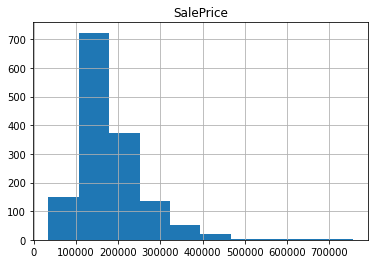

In [47]:
y.hist()

In [48]:
print('y log skew', np.log(y).skew())
print('y sqrt skew', np.sqrt(y).skew())
print('y inverse skew', (1/y).skew())
print('y YJ skew', pd.DataFrame(list(stats.yeojohnson(y))[0]).skew()[0])

y log skew SalePrice   0.12134
dtype: float64
y sqrt skew SalePrice   0.94315
dtype: float64
y inverse skew SalePrice   2.14212
dtype: float64
y YJ skew -0.00865367081719516


In [49]:
y['SalePrice'] = np.log(y['SalePrice'])

##### come back to this: try to do a YJ transform

In [50]:
# YJ is the best transformation. Use the PowerTransformer funciton.

# y['SalePrice'] = list(stats.yeojohnson(y))[0]
# print(y.skew())
# y.hist()

## Dropping columns 
* ID

In [51]:
x.shape

(2919, 76)

In [52]:
x.drop(columns = 'Id', inplace=True)

In [53]:
x.shape

(2919, 75)

## Scaling

### Identifying which columns are booleans already

In [54]:
bool_list = [] # initiate a list
for (xcolname, xcol) in x.iteritems(): # iterate through columns that
  bool_test = xcol.value_counts().index.tolist() # find the number of unique values per column
  if 1 and 0 in bool_test and len(bool_test) == 2: # if there are only 2 unique values, add them to the list
    bool_list.append(xcolname)

print(bool_list)# print the list

['CentralAir', 'HasPool', 'Has2ndFloor', 'HasGarage', 'HasBasement', 'HasFireplace']


In [55]:
for i in bool_list:
  x[i] = x[i].astype('bool')

### Selecting the columns to scale (numerics, excluding bools)

In [56]:
num_cols_to_scale = x.select_dtypes(exclude = ['object', 'bool']).columns.values.tolist()
num_cols_to_scale

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'MoSold',
 'YrSold']

### Robust Scaler

In [57]:
robust_scaler = RobustScaler().fit(x[num_cols_to_scale])
x[num_cols_to_scale] = robust_scaler.transform(x[num_cols_to_scale])

### Standard Scaler

In [58]:
# standard_scaler = StandardScaler().fit(x[num_cols_to_scale])
# x[num_cols_to_scale] = standard_scaler.transform(x[num_cols_to_scale])

## Encoding

In [59]:
cat_cols_to_encode = x.select_dtypes(include = 'object').columns.values.tolist()
cat_cols_to_encode

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [60]:
x = pd.get_dummies(x)

# Training and Predicting

## Prepping the training data
* Unstacking x back into training and test (prediction to be submitted to Kaggle).
* Splitting training data into training and test data.
* Fitting the regression model.
* Predicting the output.
* Measuring the RMSE

In [61]:
total_copy = x

In [62]:
new_test = test.shape[0]
train2 = total_copy[:train.shape[0]]
test2 = total_copy[train.shape[0]:test.shape[0] + (new_test+1)]

## Training

## Splitting the training data

In [63]:
xtrain2, xtest2, ytrain2, ytest2 = train_test_split(train2, y.SalePrice, test_size = .33, random_state = 7)

In [64]:
print('xtrain2', xtrain2.shape)
print('xtest2', xtest2.shape)
print('ytrain2', ytrain2.shape)
print('ytest2', ytest2.shape)

xtrain2 (978, 400)
xtest2 (482, 400)
ytrain2 (978,)
ytest2 (482,)


## Lasso Regression

In [65]:
las = Lasso(alpha = 0.0008).fit(xtrain2, ytrain2)

In [66]:
ypred2 = las.predict(xtest2)

In [67]:
ypred2_untrans = np.exp(ypred2)

In [68]:
ytest2_untrans = np.exp(ytest2)

### Analyzing the results

Mean Squared Error is 728,317,101.41
Root Mean Squared Error is 26,987.35
Mean Absolute Error is 15,699.30


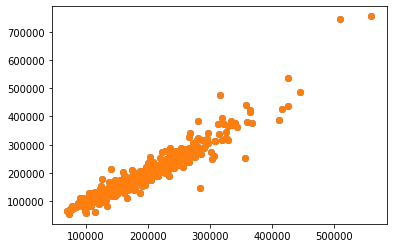

In [69]:
mse = mean_squared_error(ytest2_untrans, ypred2_untrans)
rmse = np.sqrt(mse)
mae = mean_absolute_error(ytest2_untrans, ypred2_untrans)

plt.scatter(ypred2_untrans, ytest2_untrans)
print('Mean Squared Error is', '{:,.2f}'.format(mse))
print('Root Mean Squared Error is', '{:,.2f}'.format(rmse))
print('Mean Absolute Error is', '{:,.2f}'.format(mae))
plt.scatter(ypred2_untrans, ytest2_untrans) 

In [70]:
ytest2_untrans.describe()

count      482.00000
mean    184178.47925
std      84750.40520
min      55000.00000
25%     129125.00000
50%     165750.00000
75%     218782.50000
max     755000.00000
Name: SalePrice, dtype: float64

# Predicting the results

In [82]:
submit_pred = las.predict(test2)
submit_pred_untrans = np.exp(submit_pred)
submit_pred_untrans

array([109389.07661539, 155733.77634496, 181587.52851069, ...,
       175757.77946731, 122189.1930551 , 231287.45137041])

In [93]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Colab data/test.csv')

In [98]:
test_to_submit = pd.DataFrame(test['Id'])
test_to_submit['SalePrice'] = submit_pred_untrans

In [100]:
test_to_submit.to_csv('/content/predictions.csv', index=False)